In [4]:
import numpy as np
import script
import pylab as plt
import nibabel as nib
import os
from skimage import filters
import scipy.ndimage as ndi
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd
from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import grey_dilation as gd
import BET
import morphsnakes.morphsnakes as morphsnakes
import time
from skimage.segmentation import find_boundaries as boundaries
import skimage

In [6]:
planes = np.load('planes.npy')

samps = ['Sample-1', 'Sample-2', 'Sample-3', 'Sample-4', 'Sample-5', 'Sample-A',
 'Sample-B', 'Sample-C', 'Sample-D', 'Sample-F', 'Sample-G', 'Sample-H',
 'Sample-I']

reshaped_niftis = []
for i in range(len(samps)):
    reshaped_niftis.append(os.path.join('/Users/Sinead/DC-project/Post-unskewed-reshaped/', 
                                        '{}.nii.gz'.format(samps[i])))

In [7]:
i = 5
path = reshaped_niftis[i]
samp = samps[i]

In [93]:
print samp

Sample-A


In [ ]:
img = nib.load(path)

In [52]:
array0 = img.get_data()

# 1. Remove Skin

In [54]:
def remove_skin(array):
    filtered = skimage.filters.gaussian(array, sigma=1)
    thresholded1 = np.multiply(filtered, (filtered>-200).astype(int))
    thresholded2 = np.multiply(thresholded1, (abs(thresholded1)>0.1).astype(int))
    return thresholded2

skin_mask = array0

for i in range(7):
    skin_mask = remove_skin(skin_mask)
    
skin_mask = np.multiply(skin_mask, (skin_mask>-200).astype(int))

In [59]:
array1 = np.multiply(array0, (skin_mask>0.0).astype(int))
array1 = np.multiply(array1, (array1>-200).astype(int))

# 2. Remove Skull

In [66]:
skull_mask = array1>84.0
array2 = np.multiply(array1, (array1<84.0).astype(int))

# 3. Remove Orbital Region

In [67]:
orbital_mask = skull_mask

In [68]:
for i in range(5):
    orbital_mask = bd(skull_mask)

In [71]:
array3 = np.multiply(array2, (orbital_mask==False).astype(int))

# 4. Eliminate Cerebral Ventricle 

In [77]:
array4 = np.multiply(array3, (array3>22.0).astype(int))

# 5. Cannot Create Dmap

In [82]:
array5 = BET.extract(array4, samp)

<IPython.core.display.Javascript object>


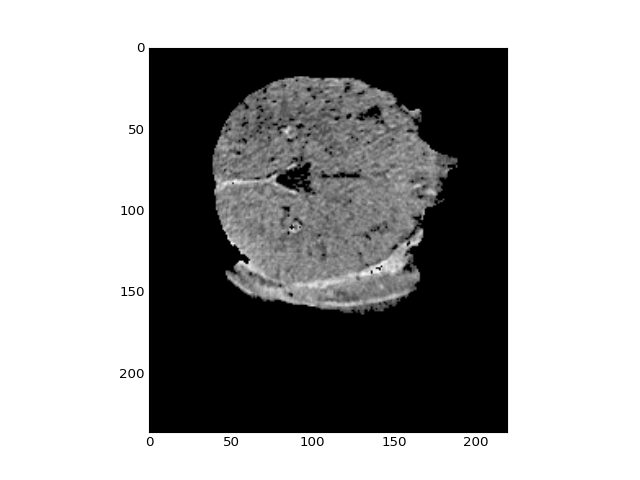

In [94]:
%matplotlib nbagg

plt.imshow(array5[:,:,80], cmap='gray')
plt.show()
plt.ion()

In [100]:
img = nib.Nifti1Image(array5, np.eye(4))
nib.save(img, '/Users/Sinead/DC-project/adapted-kondo-paper-{}.nii.gz'.format(samp))

<IPython.core.display.Javascript object>


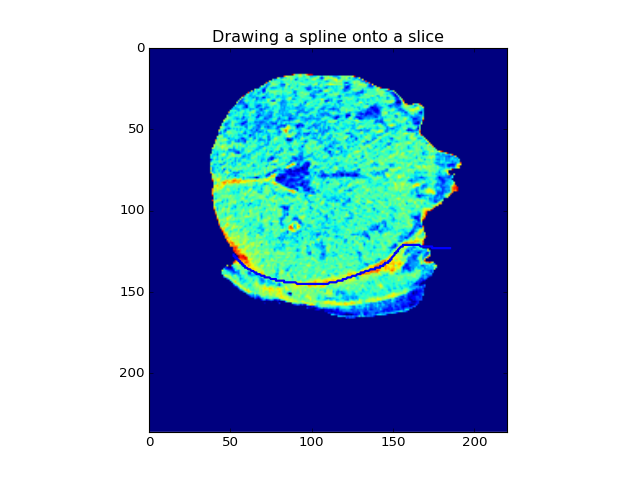

Click on points to draw a line which marks a boundary for the brain. When finished, click the submit spline button


<ipython-input-102-8dc9db54b9ed>:82: SyntaxWarning:

name 'spline' is assigned to before global declaration



In [102]:
%matplotlib nbagg

import ipywidgets
from ipywidgets import interact, fixed
from scipy import interpolate

slice_no = 80
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(data[:,:,slice_no])
ax.set_xlim([0, data.shape[1]])
ax.set_ylim([data.shape[0], 0])
ax.set_title('Drawing a spline onto a slice')
plt.ion()

coords = []
spline = []
all_spl = []

def pltspline(spl):
    global data
    global ax
    global fig
    ax.imshow(data[:,:,80])
    x = spl[0].astype(int)
    y = spl[1].astype(int)
    if len(ax.lines):
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
    else:
        ax.plot(x,y, linewidth = 2)
    fig.canvas.draw()

def onclick(event):
    global ix, iy, iz
    ix, iy, iz = event.xdata, event.ydata, slice_no
    global coords
    coords.append((ix, iy, iz))
    np_coords = np.array(coords)
    x = np_coords[:,0]
    y = np_coords[:,1]
    global tck,u
    tck, u = interpolate.splprep([x, y], s=0)
    global spline 
    spline = interpolate.splev(np.linspace(u[0], u[-1], 200), tck)
    if len(coords)>0:
        interact(pltspline, spl=fixed(spline))
    return None

print('Click on points to draw a line which marks a boundary for the brain. When finished, click the submit spline button')
cid = fig.canvas.mpl_connect('button_press_event', onclick)

from ipywidgets import Button, HBox, VBox

words = ['Start Over', 'Delete Last Point', 'Submit Spline']
items = [Button(description=w) for w in words]

def start_over_clicked(b):

    global coords
    coords = []
    global spline
    spline = np.array([0,0])
    interact(pltspline, spl=fixed(spline))
    return None

def del_lp_clicked(b):

    global coords
    coords = coords[0:-1]
    np_coords = np.array(coords)
    if len(coords) > 3:
        x = np_coords[:,0]
        y = np_coords[:,1]
        global tck,u
        tck, u = interpolate.splprep([x, y], s=0)
        global spline 
        spline = interpolate.splev(np.linspace(u[0], u[-1], 200), tck)
        interact(pltspline, spl=fixed(spline))
    else:
        coords = []
        global spline
        spline = np.array([0,0])
        interact(pltspline, spl=fixed(spline))

    return None

def submit_spline_clicked(b):
    
    fig.canvas.mpl_disconnect(cid)
    print('Spline Submitted')
    return None
    

items[0].on_click(start_over_clicked)
items[1].on_click(del_lp_clicked)
items[2].on_click(submit_spline_clicked)

HBox([items[0], items[1], items[2]])

In [62]:
# after button click
print ax
print data
print spline
print coords

Axes(0.232839,0.1;0.559322x0.8)
[[[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 ..., 
 [[-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  ..., 
  [-0. -0. -0. ..., -0

In [63]:
# after 2 button clicks
print ax
print data
print spline
print coords

Axes(0.232839,0.1;0.559322x0.8)
[[[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 ..., 
 [[-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0. -0.]
  ..., 
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]
  [-0. -0. -0. ..., -0. -0. -0.]]

 [[-0. -0. -0. ..., -0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  [-0. -0. -0. ...,  0.  0.  0.]
  ..., 
  [-0. -0. -0. ..., -0

In [112]:

x = spline[1].astype(int)
y = spline[0].astype(int)
data[x, y, slice_no] = 0
data[x-1, y, slice_no] = 0
data[x, y-1, slice_no] = 0
data[x+1, y, slice_no] = 0
data[x, y+1, slice_no] = 0
data[x-1, y-1, slice_no] = 0
data[x+1, y+1, slice_no] = 0

%matplotlib nbagg
plt.imshow(data[:,:,slice_no])
plt.show()

IndexError: list index out of range

<IPython.core.display.Javascript object>


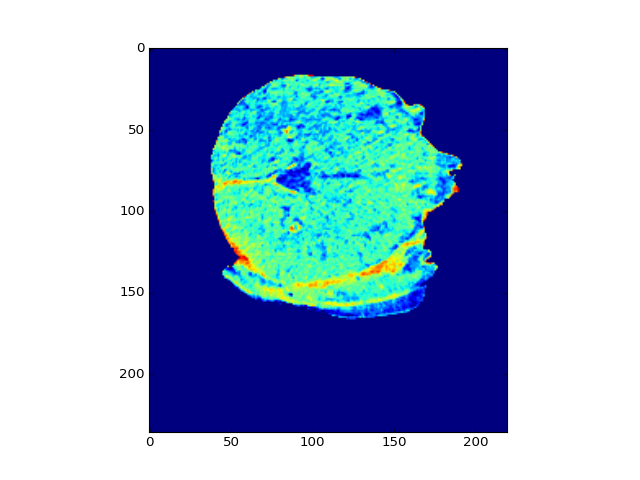

In [72]:
# data[spline[1].astype(int), spline[0].astype(int), slice_no] = 0

%matplotlib nbagg
plt.imshow(data[:,:,slice_no])
plt.show()

# data[spline[0].astype(int), spline[1].astype(int), slice_no] = 0

In [26]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446187/figure/F1/
# reference FSL BET